### Sarvam LLM Team: Assignment 2
#### Author : Harshwardhan Fartale
#### Github Repository - https://github.com/emharsha1812/Sarvam-Research-Fellow-Assignment---Harshwardhan

The subsequent cell contains an implementation of Einops, also available as `my_einops.py` in the [GitHub repository](https://github.com/emharsha1812/Sarvam-Research-Fellow-Assignment---Harshwardhan).

This content is additionally accessible as a Google Colab notebook, `Einops_Implementation.ipynb`, within the same repository.

In [ ]:
"""
This module provides a custom implementation of the 'rearrange' operation,
inspired by the einops library, designed to work specifically with NumPy arrays.

It allows for flexible tensor manipulation using a string-based pattern,
supporting operations like reshaping, transposing, splitting, merging and repeating
"""


import numpy as np
from typing import Dict, List, Tuple, Any, Set, Union
import dataclasses
import math


# --- 1. Custom Exception ---
class EinopsError(ValueError):
    """
    Custom exception class for errors encountered during einops-style operations.
    Inherits from ValueError for semantic grouping of value-related issues.
    """
    pass

# --- 2. Data Structures for Parsed Pattern ---
@dataclasses.dataclass
class ParsedExpressionData:
    """
    Holds parsed information about one side (LHS or RHS) of the einops pattern.

    Attributes:
        raw_axes: A list representing the structure of the expression.
                  Elements can be axis names (str), numeric literals (str),
                  ellipsis ('...'), or lists of strings for compositions.
        identifiers: A set of all unique named axes found in this expression.
        has_ellipsis: Boolean flag indicating if '...' is present.
        has_composition: Boolean flag indicating if axis composition `(...)` is present.
        has_anonymous_axes: Boolean flag indicating if numeric literals > 1 are present.
        has_trivial_anonymous_axis: Boolean flag indicating if '1' is present.
    """
    raw_axes: List[Union[str, List[str]]]
    identifiers: Set[str]
    has_ellipsis: bool
    has_composition: bool
    has_anonymous_axes: bool
    has_trivial_anonymous_axis: bool

@dataclasses.dataclass
class ParsedPattern:
    """
    Represents the fully parsed and validated einops pattern, containing
    the execution plan for the rearrangement.
    Attributes:
        lhs_expression: ParsedExpressionData for the left-hand side.
        decomposed_lhs_axes: List of atomic axis names on the LHS after resolving
                             compositions and ellipsis.
        rhs_expression: ParsedExpressionData for the right-hand side.
        decomposed_rhs_axes_final: List of atomic axis names on the RHS, including
                                   placeholders for repeats (`_repeat_N`), anonymous
                                   axes (`_anon_1_`), and newly named axes.
        resolved_axes_lengths: Dictionary mapping all axis names (LHS, RHS-new,
                               ellipsis, inferred) to their integer lengths.
        repeat_axes_info: Dictionary mapping axes designated for repetition (numeric
                          literals like '3' or new named axes like 'b') to their
                          target repeat length. Keys might be '_repeat_N' or 'b'.
        needs_reshaping_input: Flag if LHS involves composition or '1'.
        needs_repeating: Flag if RHS involves numeric literals > 1 or new named axes.
        needs_transposing: Flag if the order of existing axes changes from LHS to RHS.
        needs_reshaping_output: Flag if RHS involves composition or '1'.
        shape_after_lhs_reshape: The tensor shape after applying LHS compositions/splits.
        transpose_indices: Tuple of indices for np.transpose, if needed.
        final_shape: The expected shape of the output tensor.
    """
    lhs_expression: ParsedExpressionData
    decomposed_lhs_axes: List[str]
    rhs_expression: ParsedExpressionData
    decomposed_rhs_axes_final: List[str]
    resolved_axes_lengths: Dict[str, int]
    repeat_axes_info: Dict[str, int]
    needs_reshaping_input: bool
    needs_repeating: bool
    needs_transposing: bool
    needs_reshaping_output: bool
    shape_after_lhs_reshape: Tuple[int, ...]
    transpose_indices: Tuple[int, ...]
    final_shape: Tuple[int, ...]

# --- 3. Main Public Function ---
def rearrange(tensor: np.ndarray, pattern: str, **axes_lengths: int) -> np.ndarray:
    """
    Rearranges a NumPy ndarray based on the provided einops-style pattern.
    Args:
    tensor: The input NumPy array to rearrange.
    pattern: The einops-style string pattern (e.g., 'b h w c -> b c h w').
                Must contain '->'. Supports identifiers, parentheses for
                composition/decomposition, ellipsis '...', anonymous axes '1',
                and numeric literals or named axes on RHS for repetition.
    **axes_lengths: Keyword arguments specifying the lengths of named axes
                    that are either newly introduced on the RHS for repetition
                    (e.g., b=4 in 'a -> a b') or are part of an LHS composition
                    where the length cannot be inferred (e.g., h=10 in
                    '(h w) c -> h w c' if the first dim size is ambiguous).

    Returns: The rearranged NumPy ndarray.
    """
    try:
        # 1. Perform basic input validation (types, pattern structure)
        _validate_input(tensor, pattern, axes_lengths)

        # 2. Parse the pattern, validate semantics, and create an execution plan
        parsed_pattern = _parse_pattern(pattern, tensor.shape, axes_lengths)

        # 3. Execute the plan using NumPy operations
        result = _execute_rearrangement(tensor, parsed_pattern)

        return result
    except EinopsError as e:
        raise e
    except Exception as e:
        context = f" for input shape {tensor.shape} with axes_lengths={axes_lengths}." if isinstance(tensor, np.ndarray) else "."
        raise RuntimeError(f"Unhandled exception during rearrange{context}\n -> {e.__class__.__name__}: {e}") from e

# --- 4. Internal Helper Functions ---

# --- 4a. Validation (Checker Logic) ---
def _validate_input(tensor: np.ndarray, pattern: str, axes_lengths: Dict[str, int]) -> None:
    """
    Performs initial syntax and type checks on the inputs.
    Args:
        tensor: The input tensor.
        pattern: The pattern string.
        axes_lengths: Dictionary of provided axis lengths.

    Raises:
        EinopsError: If any basic validation check fails.
    """
    if not isinstance(tensor, np.ndarray):
        raise EinopsError("Input tensor must be a NumPy ndarray.")
    if not isinstance(pattern, str):
        raise EinopsError("Pattern must be a string.")
    if '->' not in pattern:
        raise EinopsError("Pattern must contain '->' separator.")
    if pattern.count('->') > 1:
        raise EinopsError("Pattern must contain exactly one '->' separator.")
    if pattern.count('(') != pattern.count(')'):
        raise EinopsError(f"Pattern has unbalanced parentheses: '{pattern}'")

    # Validate names and values provided in axes_lengths
    for name, length in axes_lengths.items():
        if not isinstance(name, str) or not name.isidentifier():
            raise EinopsError(f"Axis name '{name}' in axes_lengths is not a valid identifier.")
        # Disallow leading/trailing underscores for user-provided names
        if name.startswith('_') or name.endswith('_'):
            raise EinopsError(f"Axis name '{name}' in axes_lengths should not start or end with underscore.")
        if not isinstance(length, int) or length <= 0:
            raise EinopsError(f"Length for axis '{name}' must be a positive integer, got {length}.")

# --- 4b. Parsing Helpers ---
def _parse_expression(expression_str: str) -> ParsedExpressionData:
    """
    Parses one side (LHS/RHS) of the pattern string into structured data.
        Args:
        expression_str: The string representing either the LHS or RHS of the pattern.

    Returns:
        A ParsedExpressionData object containing the structured representation
        of the expression.

    Raises:
        EinopsError: If syntax errors like multiple ellipses, nested/unbalanced
                     parentheses, invalid tokens, duplicate identifiers within
                     the same scope (global or within a composition), or invalid
                     numeric axes (<= 0) are found.
    """
    raw_axes: List[Union[str, List[str]]] = []
    identifiers: Set[str] = set()
    has_ellipsis = False
    has_anonymous_axes = False
    has_trivial_anonymous_axis = False
    current_composition: List[str] = None
    in_composition = False
    paren_level = 0

    processed_expression = expression_str.replace('(', ' ( ').replace(')', ' ) ')
    tokens = processed_expression.split()

    for token in tokens:
        if not token:
            continue
        if token == '...':
            if has_ellipsis:
                raise EinopsError(f"Pattern side '{expression_str}' has multiple ellipses (...)")
            if paren_level > 0:
                if current_composition is None:
                    raise EinopsError(f"Internal parsing error: In composition state without active list near '{token}' in '{expression_str}'.")
                current_composition.append('...')
            else:
                raw_axes.append('...')
            has_ellipsis = True
        elif token == '(':
            if paren_level > 0:
                raise EinopsError(f"Nested parentheses are not allowed in pattern: '{expression_str}'")
            paren_level += 1
            in_composition = True
            current_composition = []
        elif token == ')':
            if paren_level == 0:
                raise EinopsError(f"Unbalanced parentheses (extra closing) in pattern: '{expression_str}'")
            paren_level -= 1
            in_composition = False
            if current_composition is not None:
                raw_axes.append(list(current_composition))
            current_composition = None
        elif token.isidentifier():
            if token.startswith('_') or token.endswith('_'):
                raise EinopsError(f"Axis name '{token}' should not start or end with underscore.")
            current_scope_identifiers = (set(current_composition) if in_composition else identifiers)
            if token in current_scope_identifiers:
                if not (in_composition and token == '1'): # Allow duplicate '1' inside composition
                    raise EinopsError(f"Duplicate identifier '{token}' in expression '{expression_str}'")
            if in_composition:
                current_composition.append(token)
            else:
                raw_axes.append(token)
            identifiers.add(token)
        elif token.isdigit():
            num_val = int(token)
            if num_val <= 0:
                raise EinopsError(f"Numeric axis must be positive, found '{token}' in '{expression_str}'")
            axis_repr = str(num_val)
            if num_val == 1:
                has_trivial_anonymous_axis = True
            else:
                has_anonymous_axes = True
            if num_val != 1:
                 current_scope_identifiers_check = (set(current_composition) if in_composition else identifiers | {ax for ax in raw_axes if isinstance(ax, str)})
                 if axis_repr in current_scope_identifiers_check:
                     raise EinopsError(f"Duplicate identifier '{axis_repr}' (numeric literal treated as identifier) in expression '{expression_str}'")
            if in_composition:
                if current_composition is None:
                     raise EinopsError(f"Internal parsing error: In composition state without active list near '{token}' in '{expression_str}'.")
                current_composition.append(axis_repr)
            else:
                raw_axes.append(axis_repr)
        else:
            if '.' in token:
                raise EinopsError("Invalid token '.' found outside ellipsis (...)")
            raise EinopsError(f"Invalid token '{token}' found during parsing of '{expression_str}'")

    if paren_level != 0:
        raise EinopsError(f"Unbalanced parentheses in pattern: '{expression_str}'")

    processed_raw_axes = []
    for axis_group in raw_axes:
        if isinstance(axis_group, list):
            if len(axis_group) == 1:
                processed_raw_axes.append(axis_group[0]) # Simplify (a) -> a
            else:
                processed_raw_axes.append(axis_group)
        else:
            processed_raw_axes.append(axis_group)

    has_actual_composition = any(isinstance(ax, list) and len(ax) > 1 for ax in processed_raw_axes)

    return ParsedExpressionData(
        raw_axes=processed_raw_axes,
        identifiers=identifiers,
        has_ellipsis=has_ellipsis,
        has_composition=has_actual_composition,
        has_anonymous_axes=has_anonymous_axes,
        has_trivial_anonymous_axis=has_trivial_anonymous_axis,
    )

# --- 4c. Main Parsing Logic ---
def _parse_pattern(pattern: str, tensor_shape: Tuple[int, ...], axes_lengths: Dict[str, int]) -> ParsedPattern:
    """Parses the complete einops pattern, performs semantic validation,
    and generates an execution plan (ParsedPattern)
    Args:
        pattern: The full einops pattern string (e.g., 'b (h w) c -> b h w c').
        tensor_shape: The shape tuple of the input NumPy array.
        axes_lengths: Dictionary of provided axis lengths for new/ambiguous axes.

    Returns:
        A ParsedPattern object containing the detailed execution plan.

    Raises:
        EinopsError: If any semantic validation fails
    """
    lhs_str, rhs_str = pattern.split('->')
    lhs_str = lhs_str.strip()
    rhs_str = rhs_str.strip()

    lhs_data = _parse_expression(lhs_str)
    rhs_data = _parse_expression(rhs_str)

    if not lhs_data.has_ellipsis and rhs_data.has_ellipsis:
        raise EinopsError(f"Ellipsis found in right side, but not left side of pattern '{pattern}'")

    resolved_axes_lengths: Dict[str, int] = axes_lengths.copy()
    decomposed_lhs_axes: List[str] = []
    current_dim_index = 0
    ellipsis_axes_names: List[str] = []
    ellipsis_start_index_in_shape = -1
    ellipsis_marker_index_in_raw = -1

    # --- Ellipsis Handling ---
    if lhs_data.has_ellipsis:
        non_ellipsis_dims_lhs = sum(1 for ax_group in lhs_data.raw_axes if ax_group != '...')
        if len(tensor_shape) < non_ellipsis_dims_lhs:
            raise EinopsError(f"Input tensor has {len(tensor_shape)} dimensions, but pattern requires at least {non_ellipsis_dims_lhs} explicit axes (excluding ellipsis). Pattern: '{lhs_str}'")
        ellipsis_ndim = len(tensor_shape) - non_ellipsis_dims_lhs
        ellipsis_axes_names = [f"_ellipsis_{i}" for i in range(ellipsis_ndim)]
        try:
            ellipsis_marker_index_in_raw = lhs_data.raw_axes.index('...')
            ellipsis_start_index_in_shape = ellipsis_marker_index_in_raw
        except ValueError:
            raise EinopsError(f"Internal error: Ellipsis flag set but '...' not found in raw LHS axes: {lhs_data.raw_axes}")
        for i, name in enumerate(ellipsis_axes_names):
            resolved_axes_lengths[name] = tensor_shape[ellipsis_start_index_in_shape + i]

    # --- Process LHS ---
    raw_axes_index = 0
    while raw_axes_index < len(lhs_data.raw_axes):
        axis_group = lhs_data.raw_axes[raw_axes_index]
        is_ellipsis_group = (axis_group == '...')

        if is_ellipsis_group:
            decomposed_lhs_axes.extend(ellipsis_axes_names)
        else:
            # Determine corresponding dimension index in tensor_shape
            current_shape_dim_index = -1
            if lhs_data.has_ellipsis:
                if raw_axes_index < ellipsis_marker_index_in_raw:
                    current_shape_dim_index = current_dim_index
                else:
                    num_groups_before_this_after_ellipsis = raw_axes_index - (ellipsis_marker_index_in_raw + 1)
                    current_shape_dim_index = ellipsis_start_index_in_shape + ellipsis_ndim + num_groups_before_this_after_ellipsis
            else:
                current_shape_dim_index = current_dim_index

            if current_shape_dim_index >= len(tensor_shape):
                raise EinopsError(f"Rank mismatch: Pattern '{lhs_str}' has more axes ({raw_axes_index+1} processed) than input tensor rank {len(tensor_shape)}.")
            dim_size = tensor_shape[current_shape_dim_index]

            if isinstance(axis_group, list):
                # Handle LHS Composition
                current_composition_axes = []
                known_axes = {}
                unknown_axes = []
                has_one_in_comp = False
                for ax in axis_group:
                     if ax == '1': has_one_in_comp = True; continue
                     elif ax.isdigit(): raise EinopsError(f"Numeric literal '{ax}' > 1 not allowed in LHS composition '{axis_group}'")
                     elif ax in resolved_axes_lengths: known_axes[ax] = resolved_axes_lengths[ax]
                     else: unknown_axes.append(ax)
                     current_composition_axes.append(ax)

                if len(unknown_axes) > 1:
                    raise EinopsError(f"Could not infer sizes for multiple axes {unknown_axes} in composition '{axis_group}' mapping to dimension {current_shape_dim_index} (size {dim_size}). Provide lengths via axes_lengths.")
                known_product = math.prod(known_axes.values()) if known_axes else 1

                if has_one_in_comp and len(unknown_axes) == 0 and dim_size != known_product:
                     raise EinopsError(f"Shape mismatch: Dimension {current_shape_dim_index} (size {dim_size}) does not match product of known axes ({known_product}) in composition '{axis_group}' which includes '1'.")

                if len(unknown_axes) == 1:
                    unknown_axis = unknown_axes[0]
                    if known_product == 0: raise EinopsError(f"Cannot infer axis size for '{unknown_axis}' when known product is zero in composition '{axis_group}'")
                    if dim_size % known_product != 0: raise EinopsError(f"Shape mismatch: Dimension {current_shape_dim_index} (size {dim_size}) is not divisible by product of known axes ({known_product}) for composition '{axis_group}'. Cannot infer '{unknown_axis}'.")
                    inferred = dim_size // known_product
                    if unknown_axis in resolved_axes_lengths and resolved_axes_lengths[unknown_axis] != inferred: raise EinopsError(f"Axis '{unknown_axis}' length mismatch: Provided/inferred earlier as {resolved_axes_lengths[unknown_axis]}, but calculated as {inferred} from shape dimension {current_shape_dim_index} (size {dim_size}) and composition '{axis_group}'.")
                    resolved_axes_lengths[unknown_axis] = inferred
                    known_axes[unknown_axis] = inferred
                elif len(unknown_axes) == 0:
                    required_product = known_product
                    if dim_size != required_product:
                        if not (has_one_in_comp and dim_size == 1 and required_product == 1): raise EinopsError(f"Shape mismatch: Dimension {current_shape_dim_index} (size {dim_size}) does not match required product ({required_product}) for composition {axis_group}.")
                decomposed_lhs_axes.extend(current_composition_axes)

            elif isinstance(axis_group, str):
                # Handle Simple LHS Axis
                if axis_group == '1':
                    if dim_size != 1: raise EinopsError(f"Shape mismatch: Dimension {current_shape_dim_index} (size {dim_size}) corresponds to pattern axis '1', but size is not 1.")
                    # Do not add '1' to decomposed_lhs_axes
                elif axis_group.isdigit():
                    raise EinopsError(f"Numeric literal '{axis_group}' > 1 is not allowed on LHS of rearrange pattern.")
                else: # Named axis
                    axis_name = axis_group
                    if axis_name in resolved_axes_lengths and resolved_axes_lengths[axis_name] != dim_size:
                        raise EinopsError(f"Axis '{axis_name}' length mismatch: Provided/inferred earlier as {resolved_axes_lengths[axis_name]}, but dimension {current_shape_dim_index} has size {dim_size}.")
                    resolved_axes_lengths[axis_name] = dim_size
                    decomposed_lhs_axes.append(axis_name)
            else:
                 raise EinopsError(f"Internal parsing error: Unexpected LHS element type {type(axis_group)}")

            current_dim_index += 1 # Increment for next non-ellipsis dimension
        raw_axes_index += 1

    # --- Create lhs_set AFTER processing LHS ---
    lhs_set = set(decomposed_lhs_axes)

    # --- Check LHS Rank Match ---
    num_pattern_groups_lhs = len(lhs_data.raw_axes)
    expected_rank_from_pattern = (num_pattern_groups_lhs - 1 + len(ellipsis_axes_names)) if lhs_data.has_ellipsis else num_pattern_groups_lhs
    if expected_rank_from_pattern != len(tensor_shape):
        raise EinopsError(f"Rank mismatch: Pattern '{lhs_str}' implies rank {expected_rank_from_pattern}, but tensor has rank {len(tensor_shape)}.")

    # --- Process RHS ---
    decomposed_rhs_axes_final: List[str] = []
    repeat_axes_info: Dict[str, int] = {}
    repeat_counter = 0
    final_shape_list: List[int] = []

    for axis_group in rhs_data.raw_axes:
        if axis_group == '...':
            decomposed_rhs_axes_final.extend(ellipsis_axes_names)
            final_shape_list.extend(resolved_axes_lengths[ax] for ax in ellipsis_axes_names)
        elif isinstance(axis_group, list):
            # Handle RHS Composition
            group_axes = []
            group_len_prod = 1
            for axis_name in axis_group:
                if axis_name == '1':
                    anon_name = f"_anon_1_{len(decomposed_rhs_axes_final) + len(group_axes)}"
                    group_axes.append(anon_name)
                    group_len_prod *= 1
                elif axis_name.isdigit():
                    repeat_len = int(axis_name)
                    repeat_axis_name = f"_repeat_{repeat_counter}"
                    repeat_axes_info[repeat_axis_name] = repeat_len
                    group_axes.append(repeat_axis_name)
                    group_len_prod *= repeat_len
                    repeat_counter += 1
                elif axis_name in resolved_axes_lengths: # Known from LHS or prev RHS
                    group_axes.append(axis_name)
                    group_len_prod *= resolved_axes_lengths[axis_name]
                elif axis_name in axes_lengths: # New named axis from kwargs
                    if axis_name in lhs_set: raise EinopsError(f"Axis '{axis_name}' provided in axes_lengths but already exists on LHS. Use only for new axes.")
                    resolved_axes_lengths[axis_name] = axes_lengths[axis_name]
                    repeat_axes_info[axis_name] = axes_lengths[axis_name]
                    group_axes.append(axis_name)
                    group_len_prod *= axes_lengths[axis_name]
                else:
                    raise EinopsError(f"Unknown axis '{axis_name}' in RHS composition '{axis_group}'")
            decomposed_rhs_axes_final.extend(group_axes)
            if len(group_axes) > 0:
                final_shape_list.append(group_len_prod)

        elif isinstance(axis_group, str):
            # Handle Simple RHS Axis
            if axis_group == '1':
                anon_name = f"_anon_1_{len(decomposed_rhs_axes_final)}"
                decomposed_rhs_axes_final.append(anon_name)
                final_shape_list.append(1)
            elif axis_group.isdigit():
                repeat_len = int(axis_group)
                repeat_axis_name = f"_repeat_{repeat_counter}"
                repeat_axes_info[repeat_axis_name] = repeat_len
                decomposed_rhs_axes_final.append(repeat_axis_name)
                final_shape_list.append(repeat_len)
                repeat_counter += 1
            else: # Named identifier
                # *** CORRECTED LOGIC START ***
                # Check 1: Is this axis known FROM THE LHS?
                if axis_group in lhs_set:
                    # Yes, it's a reused axis.
                    decomposed_rhs_axes_final.append(axis_group)
                    final_shape_list.append(resolved_axes_lengths[axis_group])
                # Check 2: Is it a NEW axis (not from LHS) whose length was provided via **axes_lengths?
                elif axis_group in axes_lengths:
                    # Yes, this is a NEW named axis for repetition.
                    # Ensure length is consistent if somehow already resolved
                    if axis_group in resolved_axes_lengths and resolved_axes_lengths[axis_group] != axes_lengths[axis_group]:
                         # This case should ideally not happen if input validation is correct
                         # If it happens, prioritize the explicitly passed length
                         resolved_axes_lengths[axis_group] = axes_lengths[axis_group]
                    elif axis_group not in resolved_axes_lengths:
                         resolved_axes_lengths[axis_group] = axes_lengths[axis_group] # Add if missing

                    # Add to repeat_axes_info
                    repeat_axes_info[axis_group] = axes_lengths[axis_group]
                    decomposed_rhs_axes_final.append(axis_group)
                    final_shape_list.append(axes_lengths[axis_group])
                # Check 3: Otherwise, it's an unknown axis.
                else:
                    context=f"Axis '{axis_group}' appears on the right side ('{rhs_str}') "
                    context+=f"but is not defined on the left side ('{lhs_str}') "
                    context+=f"and its length is not specified via axes_lengths={axes_lengths}"
                    raise EinopsError(context)
                # *** CORRECTED LOGIC END ***
        else:
            raise EinopsError(f"Internal parsing error: Unexpected RHS element type {type(axis_group)}")

    final_shape = tuple(final_shape_list)

    # --- Final Validation ---
    rhs_set_all_atomic = {ax for ax in decomposed_rhs_axes_final if not ax.startswith('_anon_1_')}
    repeat_set = set(repeat_axes_info.keys())
    extra_on_rhs = rhs_set_all_atomic - lhs_set
    missing_on_rhs = lhs_set - rhs_set_all_atomic

    # Check 1: Unaccounted axes on RHS
    if extra_on_rhs != repeat_set:
        unaccounted_extra = extra_on_rhs - repeat_set
        if unaccounted_extra: # Only error if there are truly unaccounted axes
             raise EinopsError(f"Axes {unaccounted_extra} appear on RHS but not LHS")

    # Check 2: Reduction
    if missing_on_rhs:
        raise EinopsError(f"Axes {missing_on_rhs} present on LHS but missing on RHS. Reduction is not supported by rearrange.")

    # --- Determine Execution Plan Flags ---
    needs_reshaping_input = lhs_data.has_composition or lhs_data.has_trivial_anonymous_axis
    needs_repeating = bool(repeat_axes_info)
    needs_reshaping_output = rhs_data.has_composition or any(ax.startswith('_anon_1_') for ax in decomposed_rhs_axes_final)
    shape_after_lhs_reshape = tuple(resolved_axes_lengths[ax] for ax in decomposed_lhs_axes)

    # --- Determine Transpose ---
    transpose_indices: Tuple[int, ...] = ()
    needs_transposing = False
    source_axes_order = decomposed_lhs_axes
    target_order_for_transpose = [ax for ax in decomposed_rhs_axes_final if ax in lhs_set]

    if source_axes_order != target_order_for_transpose:
        if set(source_axes_order) != set(target_order_for_transpose):
            raise EinopsError(f"Internal error: Mismatch between source axes ({set(source_axes_order)}) and target axes for transpose ({set(target_order_for_transpose)}).")
        needs_transposing = True
        try:
            transpose_indices = tuple(source_axes_order.index(ax) for ax in target_order_for_transpose)
        except ValueError as e:
            raise EinopsError(f"Internal error calculating transpose order: {e}")

    # --- Construct ParsedPattern ---
    parsed_info = ParsedPattern(
        lhs_expression=lhs_data,
        decomposed_lhs_axes=decomposed_lhs_axes,
        rhs_expression=rhs_data,
        decomposed_rhs_axes_final=decomposed_rhs_axes_final,
        resolved_axes_lengths=resolved_axes_lengths,
        repeat_axes_info=repeat_axes_info,
        needs_reshaping_input=needs_reshaping_input,
        needs_repeating=needs_repeating,
        needs_transposing=needs_transposing,
        needs_reshaping_output=needs_reshaping_output,
        shape_after_lhs_reshape=shape_after_lhs_reshape,
        transpose_indices=transpose_indices,
        final_shape=final_shape,
    )
    return parsed_info

# --- 4d. Execution (Executor Logic) ---
def _execute_rearrangement(tensor: np.ndarray, plan: ParsedPattern) -> np.ndarray:
    """
    Executes the rearrangement plan using a sequence of NumPy operations.

    Applies reshape, transpose, and repeat operations based on the flags
    and data stored in the ParsedPattern object.

    Args:
        tensor: The original input NumPy array.
        plan: The ParsedPattern object containing the execution plan.

    Returns:
        The transformed NumPy array.

    Raises:
        EinopsError: Wraps potential NumPy errors (ValueError, IndexError)
                     that might occur during reshape, transpose, or repeat,
                     adding context about the operation being performed.
    """
    current_tensor = tensor
    current_shape = tensor.shape
    try:
        # --- 1. Initial Reshape ---
        if plan.needs_reshaping_input:
            target_shape = plan.shape_after_lhs_reshape
            if math.prod(current_shape) != math.prod(target_shape):
                raise EinopsError(f"Internal error during initial reshape: Cannot reshape {current_shape} (size {math.prod(current_shape)}) to {target_shape} (size {math.prod(target_shape)}), element count mismatch.")
            current_tensor = current_tensor.reshape(target_shape)
            current_shape = current_tensor.shape

        # --- 2. Transpose ---
        if plan.needs_transposing:
            if len(plan.transpose_indices) != len(current_shape):
                raise EinopsError(f"Internal error during transpose: Transpose indices length {len(plan.transpose_indices)} != tensor rank {len(current_shape)}. Current shape: {current_shape}")
            current_tensor = np.transpose(current_tensor, axes=plan.transpose_indices)
            current_shape = current_tensor.shape

        # --- 3. Axis Insertion and Repetition ---
        needs_axis_insertion = plan.needs_repeating or any(ax.startswith("_anon_1_") for ax in plan.decomposed_rhs_axes_final)
        if needs_axis_insertion:
            temp_tensor = current_tensor
            insert_locations = []
            lhs_axes_set = set(plan.decomposed_lhs_axes)
            # Find positions where new axes need to be inserted
            for i, final_axis_name in enumerate(plan.decomposed_rhs_axes_final):
                is_new_axis = (final_axis_name.startswith(('_repeat_', '_anon_1_')) or (final_axis_name in plan.repeat_axes_info and final_axis_name not in lhs_axes_set))
                if is_new_axis:
                    insert_locations.append((i, final_axis_name))

            # Insert placeholder dimensions
            if insert_locations:
                insert_locations.sort(key=lambda x: x[0]) # Insert from left to right
                for insert_pos, axis_name in insert_locations:
                    actual_insert_pos = insert_pos # Index relative to current shape
                    temp_tensor = np.expand_dims(temp_tensor, axis=actual_insert_pos)

            # Perform repeats on the expanded tensor
            repeat_tensor = temp_tensor
            for insert_pos, axis_name in insert_locations: # Use same indices as insertion
                if axis_name in plan.repeat_axes_info:
                    repeat_len = plan.repeat_axes_info[axis_name]
                    if repeat_len > 1:
                        repeat_tensor = np.repeat(repeat_tensor, repeat_len, axis=insert_pos)

            current_tensor = repeat_tensor
            current_shape = current_tensor.shape

        # --- 4. Final Reshape ---
        # Reshape if needed due to RHS composition or if shape doesn't match target
        needs_final_reshape = plan.needs_reshaping_output or (current_shape != plan.final_shape)
        if needs_final_reshape:
            target_shape = plan.final_shape
            # Check element count before final reshape as well
            if math.prod(current_shape) != math.prod(target_shape):
                raise EinopsError(f"Internal error before final reshape: Cannot reshape {current_shape} (size {math.prod(current_shape)}) to {target_shape} (size {math.prod(target_shape)}), element count mismatch.")
            current_tensor = current_tensor.reshape(target_shape)
            current_shape = current_tensor.shape

        # --- Final Sanity Check ---
        if current_tensor.shape != plan.final_shape:
            raise EinopsError(f"Internal error: Final shape mismatch after all operations. Expected {plan.final_shape}, but got {current_shape}")

    except ValueError as ve:
        raise EinopsError(f"NumPy ValueError during execution: {ve}. Current shape during error: {current_shape}") from ve
    except IndexError as ie:
        op = "transpose" if plan.needs_transposing else "repeat/expand/reshape"
        indices = plan.transpose_indices if plan.needs_transposing else 'N/A'
        raise EinopsError(f"NumPy IndexError during {op}: {ie}. Current shape: {current_shape}. Indices/Axis info: {indices}") from ie
    except EinopsError:
         raise # Re-raise specific EinopsErrors
    except Exception as e:
        raise EinopsError(f"Unexpected NumPy error during execution: {type(e).__name__}: {e}. Current shape: {current_shape}") from e

    return current_tensor


### The purpose of the below code is to:
1. Retrieve the files 'my_einops.py' and 'sarvam.npy' from the specified GitHub repository.
2. Utilize these files within the current Colab environment.

In [1]:
import os
import sys
import numpy as np
from PIL.Image import fromarray
from IPython import get_ipython

GIT_REPO_URL = "https://github.com/emharsha1812/Sarvam-Research-Fellow-Assignment---Harshwardhan.git"
repo_name = GIT_REPO_URL.split('/')[-1].replace('.git', '')
repo_path = f"/content/{repo_name}"
!git clone {GIT_REPO_URL} {repo_path}
sys.path.insert(0, repo_path)

npy_filename = "/content/Sarvam-Research-Fellow-Assignment---Harshwardhan/sarvam.npy"

Cloning into '/content/Sarvam-Research-Fellow-Assignment---Harshwardhan'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 83 (delta 31), reused 68 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 408.93 KiB | 3.65 MiB/s, done.
Resolving deltas: 100% (31/31), done.


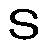

In [2]:
import os
import sys
import numpy as np
from PIL.Image import fromarray
from IPython import get_ipython

# The following code is a boilerplate snippet adapted from the Einops library.
# It is used solely for displaying NumPy ndarrays as images within this notebook.
# IMP - This functionality is for demonstration purposes only and does not affect the core Einops implementation.

def display_np_arrays_as_images():
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype="uint8"))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype="uint8"))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print("<array of shape {}>".format(obj.shape))

    ip = get_ipython()
    ip.display_formatter.formatters["image/png"].for_type(np.ndarray, np_to_png)
    ip.display_formatter.formatters["text/plain"].for_type(np.ndarray, np_to_text)

# Register the custom display formatters
ims = np.load(npy_filename, allow_pickle=False)
display_np_arrays_as_images()

# Now, displaying an image (e.g., the first image) in a Jupyter cell:
ims[0]


### Using the `my_einops` Module

Now we will utilize the `my_einops` module, which contains our custom implementation of the `rearrange` function. This module is defined in the `my_einops.py` file that we retrieved from the GitHub repository.  Specifically, we import the `rearrange` function for use in the following code examples.

In [3]:
import my_einops
import numpy as np
from my_einops import rearrange # Use the filename you saved



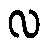

In [4]:
## Functionality One - Transposing the first two axes (dimensions)
rearrange(ims[0],"h w c -> w h c")

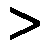

In [5]:
## Using more verbose names for axes (width height color)
rearrange(ims[3], "height width color -> width height color")


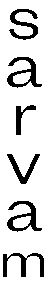

In [6]:
#seamlessly composing batch and height to a new height dimension
#rendered all images by collapsing to 3d tensor
rearrange(ims, "b h w c -> (b h) w c")

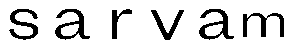

In [7]:
## Composing a new dimension of batch and width
rearrange(ims, "b h w c -> h (b w) c")

In [8]:
rearrange(ims, "b h w c -> h (b w) c").shape

(48, 288, 3)

In [9]:
# let's flatten 4d array into 1d, resulting array has as many elements as the original
rearrange(ims, "b h w c -> (b h w c)").shape

(41472,)

#### Decomposition of axis

In [10]:
rearrange(ims, "(b1 b2) h w c -> b1 b2 h w c ", b1=2).shape

(2, 3, 48, 48, 3)

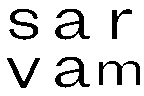

In [11]:
# finally, combine composition and decomposition:
rearrange(ims, "(b1 b2) h w c -> (b1 h) (b2 w) c ", b1=2)

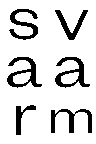

In [12]:
# slightly different composition: b1 is merged with width, b2 with height
# ... so letters are ordered by w then by h
rearrange(ims, "(b1 b2) h w c -> (b2 h) (b1 w) c ", b1=2)

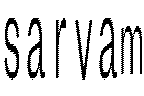

In [13]:
# move part of width dimension to height.
# we should call this width-to-height as image width shrunk by 2 and height doubled.
rearrange(ims, "b h (w w2) c -> (h w2) (b w) c", w2=2)

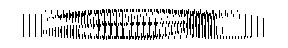

In [14]:
# rule is just as for digits in the number: leftmost digit is the most significant,
# while neighboring numbers differ in the rightmost axis.

# you can also think of this as lexicographic sort
rearrange(ims, "b h w c -> h (w b) c")

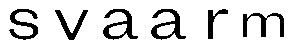

In [15]:
# what if b1 and b2 are reordered before composing to width?
rearrange(ims, "(b1 b2) h w c -> h (b1 b2 w) c ", b1=2)  # produces 'sarvam'
rearrange(ims, "(b1 b2) h w c -> h (b2 b1 w) c ", b1=2)  # produces 'svaarm'

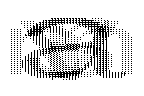

In [16]:
# interweaving pixels of different pictures
# all letters are observable
rearrange(ims, "(b1 b2) h w c -> (h b1) (w b2) c ", b1=2)

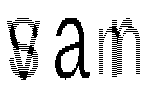

In [17]:
# interweaving along vertical for couples of images
rearrange(ims, "(b1 b2) h w c -> (h b1) (b2 w) c", b1=2)

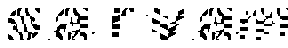

In [18]:
# split in small patches and transpose each patch
rearrange(ims, "b (h1 h2) (w1 w2) c -> (h1 w2) (b w1 h2) c", h2=8, w2=8)

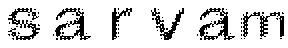

In [19]:
# stop me someone!
rearrange(ims, "b (h1 h2 h3) (w1 w2 w3) c -> (h1 w2 h3) (b w1 h2 w3) c", h2=2, w2=2, w3=2, h3=2)

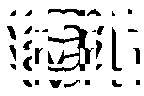

In [20]:
rearrange(ims, "(b1 b2) (h1 h2) (w1 w2) c -> (h1 b1 h2) (w1 b2 w2) c", h1=3, w1=3, b2=3)

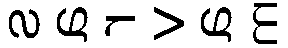

In [21]:
rearrange(ims, "b h w c -> w (b h) c")

#### Examples from the assignment doc


In [38]:
# Transpose
x = np.random.rand(3, 4)
result = rearrange(x, 'h w -> w h')
print(result)

# Split an axis
x = np.random.rand(12, 10)
result = rearrange(x, '(h w) c -> h w c', h=3)
print(result)

# Merge axes
x = np.random.rand(3, 4, 5)
result = rearrange(x, 'a b c -> (a b) c')
print(result)

# Repeat an axis
x = np.random.rand(3, 1, 5)
result = rearrange(x, 'a 1 c -> a b c', b=4)
print(result)

# Handle batch dimensions
x = np.random.rand(2, 3, 4, 5)
result = rearrange(x, '... h w -> ... (h w)')
print(result)



[[0.78477332 0.46205056 0.8734021 ]
 [0.01728646 0.76331741 0.19706538]
 [0.79833972 0.32136214 0.34468121]
 [0.03552783 0.46190837 0.84223047]]
[[[0.86957445 0.36867029 0.75893299 0.86472403 0.5610739  0.34807304
   0.42601357 0.73510869 0.74731945 0.18447276]
  [0.24992654 0.93521262 0.91646865 0.04288773 0.49486322 0.03954669
   0.94981541 0.2540327  0.35660802 0.64736503]
  [0.49824821 0.91819312 0.7744673  0.76228539 0.5862326  0.65061609
   0.3860052  0.84716942 0.87471704 0.6708572 ]
  [0.93713441 0.83594899 0.84570562 0.61490792 0.01299968 0.11302827
   0.1842591  0.04195999 0.06097325 0.74930088]]

 [[0.14253909 0.78880186 0.04886267 0.33901087 0.50704479 0.33819173
   0.16992482 0.87715586 0.12484775 0.49906012]
  [0.5410037  0.74140386 0.09676049 0.7698559  0.0952567  0.88416794
   0.2255713  0.45634464 0.36062551 0.46686579]
  [0.43157308 0.88627866 0.06218994 0.44741875 0.42300479 0.43531543
   0.37798135 0.81030431 0.97412229 0.38703933]
  [0.9202715  0.44146168 0.7134041

#### Advanced Examples

In [41]:

# Example 1: Image to Patches
# Combine splitting (h->h ph, w->w pw) and merging/transposing (ph pw c)
print("\n--- 1. Image to Patches ---")
b, c, h, w = 2, 3, 12, 16 # Input: Batch, Channels, Height, Width
ph, pw = 4, 4             # Patch size
x_img = np.arange(b * c * h * w).reshape(b, c, h, w)
print(f"Input shape (b c h w): {x_img.shape}")
# Pattern: b c (h ph) (w pw) -> b (h w) (ph pw c)
result_patches = rearrange(x_img, 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=ph, pw=pw)
print(f"Pattern: 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph={ph}, pw={pw}")
print(f"Output shape (b num_patches patch_data): {result_patches.shape}") # Expected: (2, 12, 48)


# Example 2: Space to Depth
# Move parts of spatial dimensions (h, w) into the channel dimension
print("\n--- 2. Space to Depth ---")
b, c, h, w = 4, 1, 8, 8 # Input: Batch, Channels, Height, Width
scale = 2
x_s2d = np.arange(b * c * h * w).reshape(b, c, h, w)
print(f"Input shape (b c h w): {x_s2d.shape}")
# Pattern: b c (h s1) (w s2) -> b (c s1 s2) h w
result_s2d = rearrange(x_s2d, 'b c (h s1) (w s2) -> b (c s1 s2) h w', s1=scale, s2=scale)
print(f"Pattern: 'b c (h s1) (w s2) -> b (c s1 s2) h w', s1={scale}, s2={scale}")
print(f"Output shape (b new_c new_h new_w): {result_s2d.shape}") # Expected: (4, 4, 4, 4)


# Example 3: Combine Batch and Head dims (like in Attention) + Transpose
print("\n--- 3. Combine Batch/Head & Transpose ---")
b, l, h, d = 4, 10, 8, 16 # Input: Batch, Sequence Length, Heads, Dimension per Head
x_attn = np.arange(b * l * h * d).reshape(b, l, h, d)
print(f"Input shape (b l h d): {x_attn.shape}")
# Pattern: Combine b and h, keep l, keep d -> (b h) l d
result_attn = rearrange(x_attn, 'b l h d -> (b h) l d')
print(f"Pattern: 'b l h d -> (b h) l d'")
print(f"Output shape ((b h) l d): {result_attn.shape}") # Expected: (32, 10, 16)


# Example 5: Introduce and Remove '1' dims with Transposition
print("\n--- 5. Introduce/Remove '1' Dims & Transpose ---")
a, b_dim, c = 3, 4, 5 # Input: A, B, C
x_ones = np.arange(a * b_dim * c).reshape(a, b_dim, c)
print(f"Input shape (a b c): {x_ones.shape}")
# Pattern: Add a '1' dim, transpose 'a' and 'c', merge 'b' and the new '1'
result_ones = rearrange(x_ones, 'a b c -> c (b 1) a')
print(f"Pattern: 'a b c -> c (b 1) a'")
print(f"Output shape (c (b 1) a): {result_ones.shape}") # Expected: (5, 4, 3)




--- 1. Image to Patches ---
Input shape (b c h w): (2, 3, 12, 16)
Pattern: 'b c (h ph) (w pw) -> b (h w) (ph pw c)', ph=4, pw=4
Output shape (b num_patches patch_data): (2, 12, 48)

--- 2. Space to Depth ---
Input shape (b c h w): (4, 1, 8, 8)
Pattern: 'b c (h s1) (w s2) -> b (c s1 s2) h w', s1=2, s2=2
Output shape (b new_c new_h new_w): (4, 4, 4, 4)

--- 3. Combine Batch/Head & Transpose ---
Input shape (b l h d): (4, 10, 8, 16)
Pattern: 'b l h d -> (b h) l d'
Output shape ((b h) l d): (32, 10, 16)

--- 5. Introduce/Remove '1' Dims & Transpose ---
Input shape (a b c): (3, 4, 5)
Pattern: 'a b c -> c (b 1) a'
Output shape (c (b 1) a): (5, 4, 3)


In [42]:


# Transpose
print("--- Transpose ---")
x_t = np.random.rand(3, 4)
result_t = rearrange(x_t, 'h w -> w h')
print(f"Input shape: {x_t.shape}, Pattern: 'h w -> w h'")
# Expected result shape: (4, 3)

# Split an axis
print("\n--- Split Axis ---")
x_s = np.random.rand(12, 10)
result_s = rearrange(x_s, '(h w) c -> h w c', h=3)
print(f"Input shape: {x_s.shape}, Pattern: '(h w) c -> h w c', h=3")
# Expected result shape: (3, 4, 10)

# Merge axes
print("\n--- Merge Axes ---")
x_m = np.random.rand(3, 4, 5)
result_m = rearrange(x_m, 'a b c -> (a b) c')
print(f"Input shape: {x_m.shape}, Pattern: 'a b c -> (a b) c'")
# Expected result shape: (12, 5)

# Repeat an axis (using named axis length)
print("\n--- Repeat Axis (Named) ---")
x_r_named = np.random.rand(3, 1, 5)
result_r_named = rearrange(x_r_named, 'a 1 c -> a b c', b=4)
print(f"Input shape: {x_r_named.shape}, Pattern: 'a 1 c -> a b c', b=4")
# Expected result shape: (3, 4, 5)

# Repeat an axis (using numeric literal)
print("\n--- Repeat Axis (Numeric) ---")
x_r_num = np.random.rand(3, 5)
result_r_num = rearrange(x_r_num, 'a c -> a 4 c')
print(f"Input shape: {x_r_num.shape}, Pattern: 'a c -> a 4 c'")
# Expected result shape: (3, 4, 5)

# Handle batch dimensions (...)
print("\n--- Ellipsis ---")
x_e = np.random.rand(2, 3, 4, 5)
result_e = rearrange(x_e, '... h w -> ... (h w)')
print(f"Input shape: {x_e.shape}, Pattern: '... h w -> ... (h w)'")
# Expected result shape: (2, 3, 20)

--- Transpose ---
Input shape: (3, 4), Pattern: 'h w -> w h'

--- Split Axis ---
Input shape: (12, 10), Pattern: '(h w) c -> h w c', h=3

--- Merge Axes ---
Input shape: (3, 4, 5), Pattern: 'a b c -> (a b) c'

--- Repeat Axis (Named) ---
Input shape: (3, 1, 5), Pattern: 'a 1 c -> a b c', b=4

--- Repeat Axis (Numeric) ---
Input shape: (3, 5), Pattern: 'a c -> a 4 c'

--- Ellipsis ---
Input shape: (2, 3, 4, 5), Pattern: '... h w -> ... (h w)'


#### More Examples

In [43]:
### Examples

# Add and repeat a new axis
print("\n--- Add and repeat a new axis ---")
image_hw = np.arange(6).reshape(2, 3)
result_add_repeat = rearrange(image_hw, 'h w -> h w 3')
print(f"Input shape: {image_hw.shape}, Pattern: 'h w -> h w 3'")
# Expected result shape: (2, 3, 3)

# Upsample width and merge
print("\n--- Upsample width and merge ---")
result_upsample_merge = rearrange(ims, 'b h w c -> b (2 h) (2 w) c')
print(f"Input shape: {ims.shape}, Pattern: 'b h w c -> b (2 h) (2 w) c'")
# Expected result shape: (5, 96, 96, 3)

# Upsample width and merge (alternative)
print("\n--- Upsample width and merge (alternative) ---")
result_upsample_merge_alt = rearrange(ims, 'b h w c -> b h (w 2) c')
print(f"Input shape: {ims.shape}, Pattern: 'b h w c -> b h (w 2) c'")
# Expected result shape: (5, 48, 96, 3)

# Repeat with Ellipsis
print("\n--- Repeat with Ellipsis ---")
result_repeat_ellipsis = rearrange(ims, '... h w -> ... (2 h) (2 w)')
print(f"Input shape: {ims.shape}, Pattern: '... h w -> ... (2 h) (2 w)'")
# Expected result shape: (5, 96, 96, 3)

# Repeat with Ellipsis again
print("\n--- Repeat with Ellipsis again ---")
result_repeat_ellipsis_again = rearrange(ims, 'b ... c -> b 4 ... c')
print(f"Input shape: {ims.shape}, Pattern: 'b ... c -> b 4 ... c'")
# Expected result shape: (5, 4, 48, 48, 3)

# Repeat an axis (using named axis length) - Example 2
print("\n--- Repeat Axis (Named) ---")
x_named = np.random.rand(3, 1, 5)
result_named = rearrange(x_named, 'a 1 c -> a b c', b=4)
print(f"Input shape: {x_named.shape}, Pattern: 'a 1 c -> a b c', b=4")
# Expected result shape: (3, 4, 5)

# Merge axes - Example 3
print("\n--- Merge Axes ---")
x_merge = np.random.rand(2, 3, 4, 5)
result_merge = rearrange(x_merge, '... h w -> ... (h w)')
print(f"Input shape: {x_merge.shape}, Pattern: '... h w -> ... (h w)'")
# Expected result shape: (2, 3, 20)


--- Add and repeat a new axis ---
Input shape: (2, 3), Pattern: 'h w -> h w 3'

--- Upsample width and merge ---
Input shape: (6, 48, 48, 3), Pattern: 'b h w c -> b (2 h) (2 w) c'

--- Upsample width and merge (alternative) ---
Input shape: (6, 48, 48, 3), Pattern: 'b h w c -> b h (w 2) c'

--- Repeat with Ellipsis ---
Input shape: (6, 48, 48, 3), Pattern: '... h w -> ... (2 h) (2 w)'

--- Repeat with Ellipsis again ---
Input shape: (6, 48, 48, 3), Pattern: 'b ... c -> b 4 ... c'

--- Repeat Axis (Named) ---
Input shape: (3, 1, 5), Pattern: 'a 1 c -> a b c', b=4

--- Merge Axes ---
Input shape: (2, 3, 4, 5), Pattern: '... h w -> ... (h w)'


--------------------------------------------------------------------------------
More test cases can be run via pytest using my test_einops.py file in the github
To run the test cases, first install pytest using
```bash
pip install pytest
```
Then in the project directory, open a command line and run ```pytest```

For any doubts, please feel free to contact me via email
Email - harshwardhanfartale.nith@gmail.com
